In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

d_relaxed = 0

In [2]:
cities = np.loadtxt("/kaggle/input/tsp51cities/berlin52_C_5 (1).txt")

In [3]:
# draw cities and answer map
def drawMap(cities, answer, nCluster=5, title=""):
    colors={0:"blue", 1:"orange", 2:"green", 3:"red", 4:"purple"}
    clusters = [[] for i in range(nCluster)]
    for city in cities:
        clusters[int(city[3])].append(city)

    for i in range(len(clusters)):
        city = clusters[i][0]
        plt.plot(city[1], city[2], color=colors[i], marker='o', label=f"priority: {i}")
        plt.annotate(int(city[0]), (city[1], city[2]))
        plt.legend()
        for j in range(1, len(clusters[i])):
            city = clusters[i][j]
            plt.plot(city[1], city[2], color=colors[i], marker='o')
            plt.annotate(int(city[0]), (city[1], city[2]))

    for i in range(len(answer)):
        try:
            first = int(answer[i])
            secend = int(answer[i + 1])

            plt.plot([cities[first-1][1], cities[secend-1][1]], [cities[first-1][2], cities[secend-1][2]], "gray")
        except:
            continue

    first = int(answer[0])
    secend = int(answer[-1])
    plt.plot([cities[first-1][1], cities[secend-1][1]], [cities[first-1][2], cities[secend-1][2]], "red")
    plt.title(title)
    plt.show()

In [4]:
dis_mat = []
for cityA in cities:
    dis_vec = []
    for cityB in cities:
        dis = ((cityA[1] - cityB[1])**2 + (cityA[2] - cityB[2])**2)**0.5
        dis_vec.append(dis)
    dis_mat.append(dis_vec)

In [5]:
# hàm tính tổng khoảng cách
def totalDistance(individual):
    #cities: là 1 lời giải (cá thể) dưới dạng danh sách các thành phố sẽ đi qua
    # ví dụ n = 5: [[*3,15,10],[*1,5,10],[*2,50,34],[*5,1,20],[*4,23,31]]
    summ = 0
    n = len(individual)
    for i in range(n - 1):
        cityA = int(individual[i]) - 1
        cityB = int(individual[i + 1]) - 1
        summ += dis_mat[cityA][cityB]
    
    # quay lại thành phố đầu tiên
    cityA = int(individual[0]) - 1
    cityB = int(individual[-1]) - 1
    summ += dis_mat[cityA][cityB]
    
    return summ

def nOfBlindingConstrains(individual):
    count = 0
    n = len(individual)
    for i in range(n):
        for j in range(i+1, n):
            cityA = int(individual[i]) - 1
            cityB = int(individual[j]) - 1
#             if cityA == 41:
#                 print(f'{cityA + 1}: {cities[cityA][3]} to {cityB + 1}: {cities[cityB][3]}')
            if cities[cityA][3] - cities[cityB][3] > d_relaxed:
                count += 1
    return count

def fitness(individual):
    return (nOfBlindingConstrains(individual)/15 + 1)*totalDistance(individual)

In [6]:
# khởi tạo quần thể ban đầu 
def initPopulation(cities, size):
    population = []

    for i in range(size):
        invi = list(np.array(cities.copy())[:,0])
        random.shuffle(invi)
        distance = fitness(invi)
        population.append([distance, invi])

    return population

In [7]:
# Toán tử lai 1 điểm cắt
#   father1: 2,3,5|1,4    father2: 1,3,5|4,2     điểm cắt: 3
# new_invi1: 1,3,5,2,4  new_invi2: 2,3,5,1,4
def singlePointCrossover(father1, father2, lenCities=51):
    point = random.randint(0, lenCities - 1)
    
    new_invi1 = father2[0:point]
    for invi in father1:
        if invi not in new_invi1:
            new_invi1.append(invi)
            
    new_invi2 = father1[0:point]
    for invi in father2:
        if invi not in new_invi2:
            new_invi2.append(invi)
            
    return new_invi1, new_invi2

# Toán tử lai 2 điểm cắt
#   father1: 6,2|4,3|1,5    father2: 6,1|3,5|4,2     điểm cắt: 2,4
# new_invi1: 4,1,3,5,6,2  new_invi2: 5,2,4,3,6,1
def multiPointCrossover(father1, father2, lenCities=51):
    points = sorted(random.sample(father1, 2))
    point1 = int(points[0]) - 1
    point2 = int(points[1]) - 1
    
    new_invi1 = father2[point1:point2]
    c1 = 0
    c2 = 0
    for invi in father1:
        if invi not in new_invi1:
            c1 += 1
            if c1 <= point1:
                new_invi1.append(invi)
            else:
                new_invi1.insert(c2, invi)
                c2 += 1
            
            
    new_invi2 = father1[point1:point2]
    c1 = 0
    c2 = 0
    for invi in father2:
        if invi not in new_invi2:
            c1 += 1
            if c1 <= point1:
                new_invi2.append(invi)
            else:
                new_invi2.insert(c2, invi)
                c2 += 1
                
    return new_invi1, new_invi2

# Toán tử lai vòng
# father1: 12345678
# father2: 85213647
# start=1 => inv1: 1**4**78 => 15243678
# start=2 => inv2: *23*5*** => 82315647
def cycleCrossover(father1, father2, lenCities=51):
    father1 = [int(s) for s in father1]
    father2 = [int(s) for s in father2]
    
    points = sorted(random.sample([i for i in range(lenCities)], 2))
    p1 = int(points[0])
    p2 = int(points[1])
    
    # inv1
    inv1 = list(np.zeros(lenCities, dtype=np.int8))
    inv1[p1] = father1[p1]
    s1 = p1
    count = 0
    while father2[s1] != father1[p1] and count != lenCities:
        count += 1
        s1 = father2[s1] - 1
        inv1[s1] = father1[s1]
    
    for city_i in father2:
        if city_i not in inv1:
            for i in range(lenCities):
                if inv1[i] == 0:
                    inv1[i] = city_i
                    break
    
    # inv2
    inv2 = list(np.zeros(lenCities, dtype=np.int8))
    inv2[p2] = father1[p2]
    s2 = p2
    count = 0
    while father2[s2] != father1[p2] and count != lenCities:
        count += 1
        s2 = father2[s2] - 1
        inv2[s2] = father1[s2]
    
    for city_i in father2:
        if city_i not in inv2:
            for i in range(lenCities):
                if inv2[i] == 0:
                    inv2[i] = city_i
                    break
    
#     inv1 = [np.str_(s) for s in inv1]
#     inv2 = [np.str_(s) for s in inv2]
    
    return inv1, inv2

In [8]:
# đột biến: chọn ngẫu nhiên 2 thành phố rồi đổi chỗ cho nhau, thực hiện 2 lần
# 2,1,5,3,4 => 4,1,5,3,2 => 1,4,5,3,2
def mutation(father, lenCities=51):
    new_invi = father.copy()
    for _ in range(2):
        points = random.sample(new_invi, 2)
        temp = new_invi[int(points[0]) - 1]
        new_invi[int(points[0]) - 1] = new_invi[int(points[1]) - 1]
        new_invi[int(points[1]) - 1] = temp
        
    return new_invi

In [9]:
def tournaments(old_population, new_invivduals, population_size = 100):
    new_population = []
    k1 = 2
    k2 = 2
    
    # giữ lại k1 cá thể tốt nhất của quần thể cũ
    tmp1 = sorted(old_population)
    for i in range(k1):
        new_population.append(tmp1[i])
    
    # giữ lại k2 cá thể mới được sinh ra
    tmp2 = sorted(new_invivduals)
    for i in range(k2):
        new_population.append(tmp2[i])
        
    # lấy ngẫu nhiên k3 cá thể trong các cá thể còn lại
    tmp3 = tmp1[k1:] + tmp2[k2:]
    k3 = population_size - k1 - k2
#     weights = []
#     for i in range(len(tmp3)):
#         weights.append(tmp3[i][0])
    new_population = new_population + random.choices(tmp3, k=k3)
    
    return new_population

In [10]:
def GA(
    population,
    lenCities = 51,
    population_size = 100,
    num_of_generations = 10000,
    crossover_rate = 0.9,
    mutation_rate = 0.1,
    crossover_func=singlePointCrossover,
    k = 4
):
    
    fit = [] # lưu lại cá thể tốt nhất trong mỗi thế hệ
    fit.append(sorted(population)[0][0])
    
    for _ in range(num_of_generations):
        new_inviduals = []
        
        # sinh population_size cá thể mới
        n = int(population_size/2)
        for _i in range(n):
            
            # xảy ra quá trình lai ghép (crossover)
            if random.random() <= crossover_rate:
                # chọn cá thể tốt nhất trong 'k' cá thể ngẫu nhiên làm father1
                father1 = sorted(random.choices(population, k=k))[0][1]
                
                # chọn cá thể tốt nhất trong 'k' cá thể ngẫu nhiên làm father2
                father2 = sorted(random.choices(population, k=k))[0][1]
                
                # thực hiện lai ghép 2 cá thể này
                inv1, inv2 = crossover_func(father1, father2, lenCities)
                
                # xảy ra quá trình đột biến (mutation)
                if random.random() <= mutation_rate:
                    inv1 = mutation(inv1, lenCities)
                    inv2 = mutation(inv2, lenCities)
            
            # nếu không có lai ghép xảy ra thì thực hiện lấy ngẫu nhiên 2 cá thể trong quần thể cũ
            else:
                inv1 = random.choices(population)[0][1]
                inv2 = random.choices(population)[0][1]
            
            new_inviduals.append([fitness(inv1), inv1])
            new_inviduals.append([fitness(inv2), inv2])
            
        population = tournaments(population, new_inviduals, population_size)
        
        best_invi = sorted(population)[0]
        if _ % 100 == 0:
            print(f'Loop: {_}, Fitness: {best_invi[0]}, Distance: {totalDistance(best_invi[1])}, Blinding constrains: {nOfBlindingConstrains(best_invi[1])}')
        fit.append(sorted(population)[0][0])
        
    return sorted(population), fit

In [11]:
population = initPopulation(cities, size=100) # Khởi tạo quần thể đầu tiên
pop, fit = GA(population=population, crossover_func=singlePointCrossover, lenCities=len(cities))

Loop: 0, Fitness: 624834.5664233927, Distance: 28061.432623805063, Blinding constrains: 319
Loop: 100, Fitness: 103240.07723980115, Distance: 17017.59514941777, Blinding constrains: 76
Loop: 200, Fitness: 30511.023197567727, Distance: 14763.39832140374, Blinding constrains: 16
Loop: 300, Fitness: 27013.206616220516, Distance: 15584.542278588759, Blinding constrains: 11
Loop: 400, Fitness: 16602.2222415454, Distance: 13835.185201287835, Blinding constrains: 3
Loop: 500, Fitness: 14784.79370037712, Distance: 12320.661416980935, Blinding constrains: 3
Loop: 600, Fitness: 13989.565938460939, Distance: 11657.971615384116, Blinding constrains: 3
Loop: 700, Fitness: 13908.413286593777, Distance: 11590.344405494814, Blinding constrains: 3
Loop: 800, Fitness: 13587.579857661965, Distance: 11322.983214718304, Blinding constrains: 3
Loop: 900, Fitness: 13394.717404194515, Distance: 11162.26450349543, Blinding constrains: 3
Loop: 1000, Fitness: 11952.853086321786, Distance: 11952.853086321786, Bli

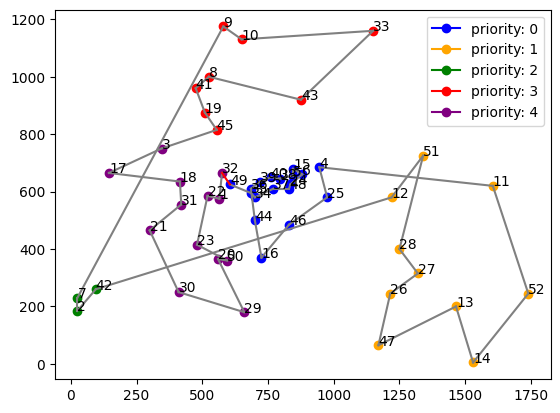

In [12]:
drawMap(cities, pop[0][1])

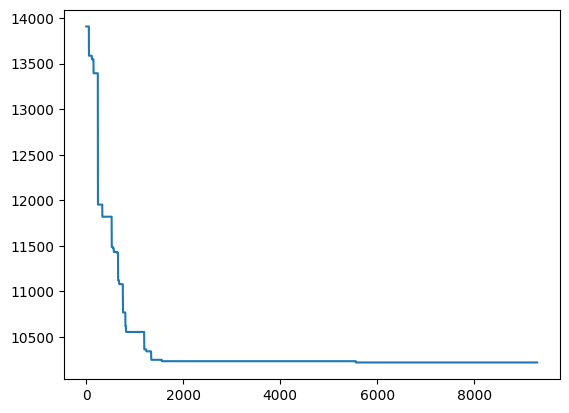

In [13]:
data=fit[700:]
x=[i for i in range(len(data))]
plt.plot(x, data, label="One Point")

In [14]:
print(pop[0][1])

[49.0, 35.0, 34.0, 37.0, 48.0, 24.0, 6.0, 15.0, 5.0, 38.0, 40.0, 39.0, 36.0, 44.0, 16.0, 46.0, 25.0, 4.0, 11.0, 52.0, 14.0, 13.0, 47.0, 26.0, 27.0, 28.0, 51.0, 12.0, 42.0, 2.0, 7.0, 9.0, 10.0, 33.0, 43.0, 8.0, 41.0, 19.0, 45.0, 3.0, 17.0, 18.0, 31.0, 21.0, 30.0, 29.0, 20.0, 50.0, 23.0, 22.0, 1.0, 32.0]
